In [431]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from keras.layers import Flatten

In [432]:
data = pd.read_csv('labelled_dataset.csv',index_col=0)
data = data[['labels','body','parent','score']]
data.head(2)

,labels,body,parent,score
0,supporting,no question want thank post topic birth contro...,updated september scroll downhi lengthy post c...,31
1,supporting,holy shit thank much someone recently turn sup...,updated september scroll downhi lengthy post c...,7


## Checking Label Distribution and Assigning Weights

In [433]:
data.labels.value_counts()

commenting     614
supporting     299
denying        137
questioning    105
Name: labels, dtype: int64

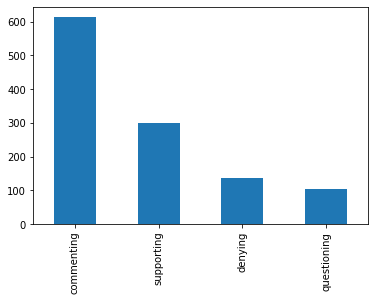

In [434]:
data.labels.value_counts().plot(kind='bar')

In [435]:
# turning into integers
data.loc[data['labels'] == 'supporting', 'labels'] = 0
data.loc[data['labels'] == 'denying', 'labels'] = 1
data.loc[data['labels'] == 'questioning', 'labels'] = 2
data.loc[data['labels'] == 'commenting', 'labels'] = 3
data.head(2)

,labels,body,parent,score
0,0,no question want thank post topic birth contro...,updated september scroll downhi lengthy post c...,31
1,0,holy shit thank much someone recently turn sup...,updated september scroll downhi lengthy post c...,7


In [436]:
# one-hot encoding
labels = to_categorical(data['labels'], num_classes=4)
labels

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

## Vectorizing with Doc2Vec

In [458]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import numpy as np

# documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(common_texts)]
comments = [TaggedDocument(row[1][2], [index]) for index, row in data.iterrows()]
source = [TaggedDocument(row[1][3], [index]) for index, row in data.iterrows()]

In [459]:
model_comments = Doc2Vec(comments, vector_size=5, window=2, min_count=1, workers=4)
model_source = Doc2Vec(source, vector_size=5, window=2, min_count=1, workers=4)

W0722 11:04:36.337714 11096 base_any2vec.py:723] consider setting layer size to a multiple of 4 for greater performance
W0722 11:04:36.338711 11096 doc2vec.py:1314] Each 'words' should be a list of words (usually unicode strings). First 'words' here is instead plain <class 'str'>.
W0722 11:04:36.485318 11096 base_any2vec.py:1386] under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
W0722 11:04:36.487313 11096 base_any2vec.py:723] consider setting layer size to a multiple of 4 for greater performance
W0722 11:04:36.488310 11096 doc2vec.py:1314] Each 'words' should be a list of words (usually unicode strings). First 'words' here is instead plain <class 'str'>.
W0722 11:04:37.018743 11096 base_any2vec.py:1386] under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


In [497]:
final_vec_list = [
    np.append(model_comments.docvecs[i], model_source.docvecs[i])
    for i in range(len(model_comments.docvecs))
]

In [498]:
np_vec_list = np.asarray(final_vec_list)

In [724]:
X_train, X_test, Y_train, Y_test = train_test_split(np_vec_list, labels, test_size=0.2)

## Modeling with LSTM

In [725]:
data.shape

(1155, 4)

In [726]:
X_train.shape

(924, 10)

In [727]:
Y_train = np.asarray(Y_train)

In [728]:
Y_test = np.asarray(Y_test)

In [729]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [730]:
# label weights

# .394     .39   .398    .411
#c = 12.0
#s = 23.0   24   23.4     23.5
#d = 48.0
#q = 60.0

c = 11.5
s = 23.1
d = 45.5
q = 55.5

In [ ]:
epochs = 100
emb_dim = 128
batch_size = 64

model = Sequential()
model.add(LSTM(30))
model.add(Dense(output_dim=4,activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])
# history = model.fit(X_train,Y_train,batch_size=batch_size,epochs=epochs,class_weight={0:s,1:d,2:q,3:c},validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])
history = model.fit(X_train,Y_train,batch_size=batch_size,epochs=epochs,class_weight={0:s,1:d,2:q,3:c},validation_split=0.2)
model.summary()

c:\users\limri\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=4)`
  import sys


Train on 739 samples, validate on 185 samples
Epoch 1/100


In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
np_vec_shaped = np.reshape(np_vec_list,(np_vec_list.shape[0],1,np_vec_list.shape[1]))
pred = model.predict(np_vec_shaped)

In [ ]:
ary = []
lb = ['supporting', 'denying', 'questioning', 'commenting']
for i in range(pred.shape[0]):
    ary.append(lb[np.argmax(pred[i])])

In [ ]:
sup = [1.,0.,0.,0.]
den = [0.,1.,0.,0.]
que = [0.,0.,1.,0.]
com = [0.,0.,0.,1.]

In [ ]:
test = []
for i in range(np_vec_shaped.shape[0]):
    if( list(np_vec_shaped[i]) == sup ):
        test.append('supporting')
    elif( list(np_vec_shaped[i]) == den ):
        test.append('denying')
    elif( list(np_vec_shaped[i]) == que ):
        test.append('questioning')
    else:
        test.append('commenting')


In [ ]:
results = pd.DataFrame(test)
results.columns = ['test']
results['predictions'] = ary

In [ ]:
results.head()

In [ ]:
results.predictions.value_counts().plot(kind='bar')

In [ ]:
accr = model.evaluate(np_vec_shaped,labels)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))